# Final Project

**Full Name:** Maria Veronica <br>
**UNI**: mv2855

Quantitative trading is a stock trading strategy that relies on mathematical models to identify trading opportunities.

Some quantitative trading strategies involve choosing a particular stock and calculating the moving average of its price over a specific period of time (like 10 days, 20 minutes, 4 weeks, or any other period of time you choose). One simple strategy would be to go long (buy) a stock when it is trading below its moving average (assuming it is undervalued), and sell your stock when it is trading above its moving average (assuming it is overvalued). In short:

- Price < Moving Average, security is undervalued, buy it.
- Price > Moving Average, security is overvalued, sell it.

Your task is to evaluate this trading strategy using Python.

To start, pick any company from the S&P 500 and download the historical prices of its stock. Clean your data, run the strategy above, and calculate the return. Some guidance for how to do this:

- Create a column with the moving average and check for each row if the price is higher/lower than the moving average. You can create a new “theoretical” security that is the result of your trading strategy — i.e. it has the return of the security when you were long, and zero otherwise.
- Use Pandas’ cumprod() function to return the cumulative product of a column. This will help you calculate the cumulative return over time.


## 1. Importing dependencies and declaring variables

In [975]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# import matplotlib.dates as mdates
# from matplotlib.dates import DateFormatter
from alpha_vantage.timeseries import TimeSeries

In [976]:
# accessing with api key
with open('alphavantage_api_key.txt') as file:
    alphavantage_api_key = file.read()

### 📌 &nbsp; Change variables here:

In [977]:
# list of variables
stock_name = 'HOOD'
ma_period = 30 # moving average period in days

In [978]:
# using get_daily_adjusted function from the Aplha Vantage API to extract historical daily prices and put it into a data frame
ts = TimeSeries(key=alphavantage_api_key, output_format='pandas')
df, meta_data = ts.get_daily_adjusted(stock_name, outputsize='full')

In [979]:
# snapshot of df
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2021-10-20,41.8933,42.44,41.0200,41.83,41.83,4039543.0,0.0,1.0
2021-10-19,40.9100,41.80,40.5400,41.70,41.70,4529214.0,0.0,1.0
2021-10-18,40.9500,41.25,40.3100,40.65,40.65,4019789.0,0.0,1.0
2021-10-15,41.6410,41.70,40.8601,41.03,41.03,2579553.0,0.0,1.0
2021-10-14,40.5900,41.79,40.5500,40.93,40.93,3827495.0,0.0,1.0


In [980]:
# meta data of df
meta_data

{'1. Information': 'Daily Time Series with Splits and Dividend Events',
 '2. Symbol': 'HOOD',
 '3. Last Refreshed': '2021-10-20',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

## 2. Cleaning up the data frame to give the daily *adjusted close price* of the stock

In [981]:
# sorting the data chronologically
df.sort_values('date', inplace=True)

# dropping non-essential columns
df.drop(columns=['1. open', '2. high', '3. low', '4. close', '6. volume', '7. dividend amount', '8. split coefficient'], inplace=True)

# renaming column to "close"
df.rename(columns={'5. adjusted close':'close'}, inplace=True)

In [982]:
# snapshot of clean df
df.head()

,close
date,
2021-07-29,34.82
2021-07-30,35.15
2021-08-02,37.68
2021-08-03,46.80
2021-08-04,70.39


<AxesSubplot:xlabel='date'>

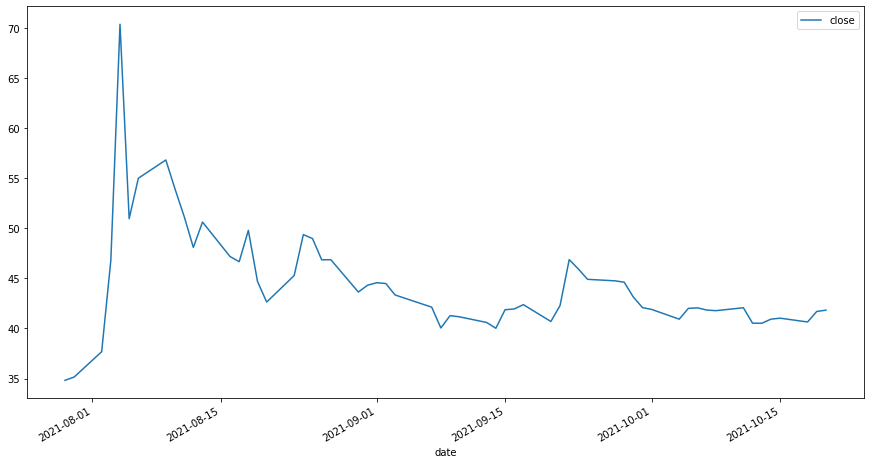

In [983]:
# quick plot of clean df
df.plot(figsize=(15,8))

## 3. Create a moving average column with the variable `ma_period` declared on step 1

In [984]:
# create moving average column based on the period selected
df['moving_avg'] = df['close'].rolling(ma_period).mean()

# filtering only data for the period of trading, in this case starting from 2019 onwards
df_trade = df.loc['2019':, ['close', 'moving_avg']]

<AxesSubplot:xlabel='date'>

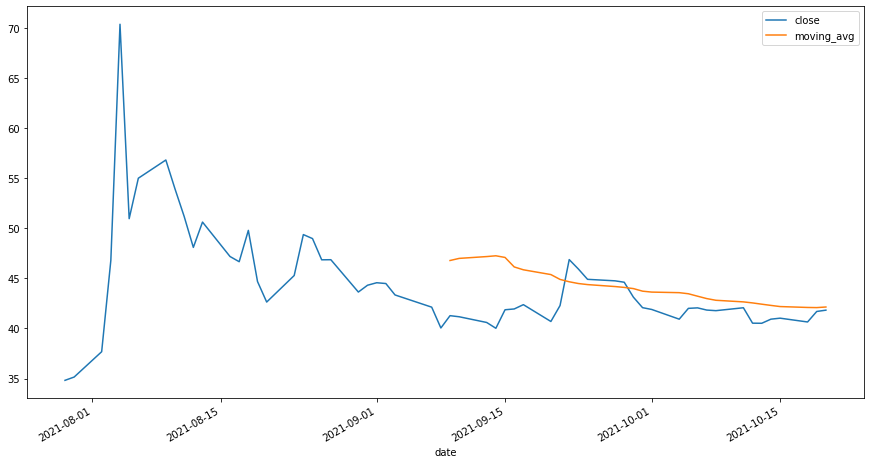

In [985]:
# quick plot of the two curves
df_trade.plot(figsize=(15,8))

## 4. Create the buy and sell signal to perform the trade

The moving average trading strategy will be programmed as follow:
- On the day that price moves **above** moving average, `BUY` the stock and `HOLD` the position
- On the day that price moves **below** moving average, `SELL` the previously bought stock

In [986]:
# create new column to indicate buy and sell action
df_trade['action'] = ''

# place the iloc indexes of each column to variables for easier reference
close_col_index = df_trade.columns.get_loc('close')
moving_avg_col_index = df_trade.columns.get_loc('moving_avg')
action_col_index = df_trade.columns.get_loc('action')

# this function checks if the close price < moving avg price on (day-1) AND the close price > moving avg price today, THEN we should BUY the stock
# respectively if the close price > moving avg price on (day-1) AND the close price < moving avg price today, THEN we should SELL the stock
for i in range(1, len(df_trade)):
    if (df_trade.iloc[i-1,close_col_index] < df_trade.iloc[i-1,moving_avg_col_index]) & (df_trade.iloc[i,close_col_index] > df_trade.iloc[i,moving_avg_col_index]):
        df_trade.iloc[i,action_col_index] = 'Buy'
    elif (df_trade.iloc[i-1,close_col_index] > df_trade.iloc[i-1,moving_avg_col_index]) & (df_trade.iloc[i,close_col_index] < df_trade.iloc[i,moving_avg_col_index]):
        df_trade.iloc[i,action_col_index] = 'Sell'
    else:
        df_trade.iloc[i,action_col_index] = ''

# actions are allocated on the trade days
df_trade.tail(10)


,close,moving_avg,action
date,,,
2021-10-07,41.84,42.986667,
2021-10-08,41.78,42.817333,
2021-10-11,42.07,42.657333,
2021-10-12,40.53,42.553667,
2021-10-13,40.52,42.427000,
2021-10-14,40.93,42.305667,
2021-10-15,41.03,42.190333,
2021-10-18,40.65,42.100333,
2021-10-19,41.70,42.086000,


### ⚠️ &nbsp; Handling exceptions

In order to make sure that every trade has both BUY and SELL actions, these adjustments need to be done:
1. If the **start price of the period is already above the moving average**, it can be assumed that the stock needs to be bought on the first day
2. If the **end price of the period is still below the moving average** (position is still held at the end of period), it can be assumed that the stock need to be sold (unwound) at the last day of the period

In [987]:
# printing the first instances of the BUY and SELL actions
print(f"First occurence of BUY order: {df_trade['action'].eq('Buy').idxmax()}")
print(f"First occurence of SELL order: {df_trade['action'].eq('Sell').idxmax()}")

# set first row as 'Buy' if the start price of the period is already above the moving average price
if df_trade['action'].eq('Buy').idxmax() > df_trade['action'].eq('Sell').idxmax():
    df_trade.iloc[0,action_col_index] = 'Buy'
    print("First row set to BUY")
else:
    df_trade.iloc[0,action_col_index] = df_trade.iloc[0,action_col_index]
    print("No change")

print("-"*10)

# printing the last instances of the BUY and SELL actions
print(f"Last occurence of BUY order: {df_trade['action'].where(df_trade['action'] == 'Buy').last_valid_index()}")
print(f"Last occurence of SELL order: {df_trade['action'].where(df_trade['action'] == 'Sell').last_valid_index()}")

# set last row as 'Sell' if the end price of the period is still above the moving average price
if df_trade['action'].where(df_trade['action'] == 'Buy').last_valid_index() > df_trade['action'].where(df_trade['action'] == 'Sell').last_valid_index():
    df_trade.iloc[len(df_trade)-1,action_col_index] = 'Sell'
    print("Last row set to SELL")
else:
    df_trade.iloc[len(df_trade)-1,action_col_index] = df_trade.iloc[len(df_trade)-1,action_col_index]
    print("No change")
    
print("-"*10)


First occurence of BUY order: 2021-09-22 00:00:00
First occurence of SELL order: 2021-09-29 00:00:00
No change
----------
Last occurence of BUY order: 2021-09-22 00:00:00
Last occurence of SELL order: 2021-09-29 00:00:00
No change
----------


In [988]:
# filtering only days with actions
df_action = df_trade.loc[df_trade['action'] != '', ['close', 'action']]
df_action.tail(10)

,close,action
date,,
2021-09-22,46.88,Buy
2021-09-29,43.13,Sell


## 5. Calculate cumulative PNL of the trading activities

In [989]:
# create a new data frame to summarize trades in a row format
df_pnl = df_action.loc[df_action['action'] == 'Buy', ['close']]

# rename column to buy_px
df_pnl.rename(columns={'close':'buy_px'}, inplace=True)

# insert a new column from a list of the SELL prices
df_pnl['sell_px'] = df_action.loc[df_action['action'] == 'Sell', ['close']]['close'].tolist()

# insert a new column for the trade dates of the SELL actions
df_pnl['sold_date'] = df_action.loc[df_action['action'] == 'Sell', ['close']].index.tolist()

# create column that shows the difference in SELL price and BUY price
df_pnl['pnl'] = df_pnl['sell_px'] - df_pnl['buy_px']

# convert that into percentage to get return per trade
df_pnl['return_pct'] = 100*df_pnl['pnl']/df_pnl['buy_px']

# calculate cumulative return (in %) using cumprod() function
df_pnl['sell_over_buy'] = df_pnl['sell_px']/df_pnl['buy_px']
df_pnl['cumulative_return'] = (df_pnl['sell_over_buy'].cumprod()-1)*100 # in percentage

df_pnl

,buy_px,sell_px,sold_date,pnl,return_pct,sell_over_buy,cumulative_return
date,,,,,,,
2021-09-22,46.88,43.13,2021-09-29,-3.75,-7.999147,0.920009,-7.999147


In [990]:
print(f"Total number of trades: {len(df_pnl)}")

Total number of trades: 1


# 6. Final results

In [991]:
print("-"*10)
print(f"Average stock price BOUGHT: ${df_pnl['buy_px'].mean():.2f}")
print(f"Average stock price SOLD: ${df_pnl['sell_px'].mean():.2f}")
print("-"*10)
print(f"Total cumulative return: {(df_pnl['cumulative_return'][len(df_pnl)-1]):.2f}%")


----------
Average stock price BOUGHT: $46.88
Average stock price SOLD: $43.13
----------
Total cumulative return: -8.00%


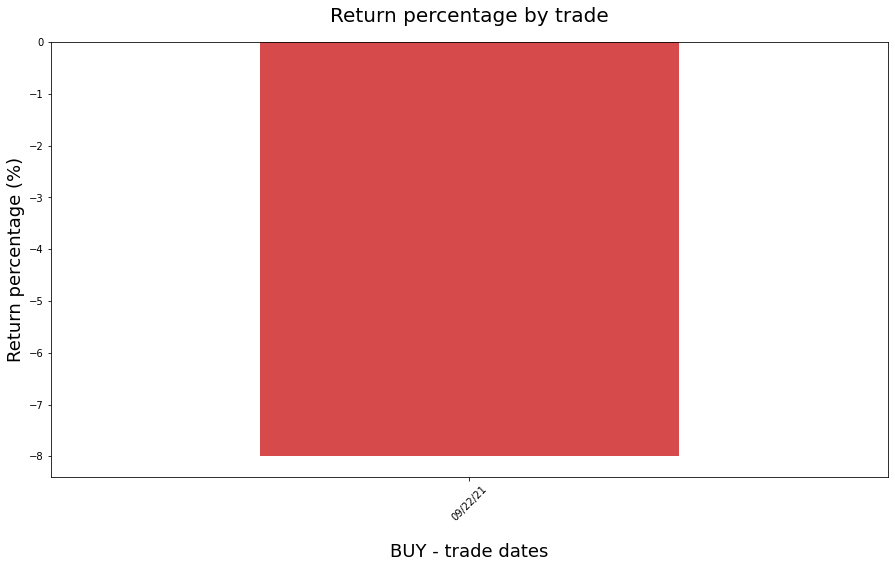

In [992]:
# Using matplotlib to chart the percentage return of each trade
ax = df_pnl['return_pct'].plot(kind='bar', figsize=(15, 8), color=(df_pnl['return_pct'] > 0).map({True: '#63B262', False: '#D74A4B'}))
ax.set_xticklabels([x.strftime("%m/%d/%y") for x in df_pnl.index], rotation=45)
ax.set_ylabel('Return percentage (%)', fontsize=18)
ax.set_xlabel('BUY - trade dates', fontsize=18, labelpad=20)
ax.set_title('Return percentage by trade', fontsize=20, pad=20)

plt.show()

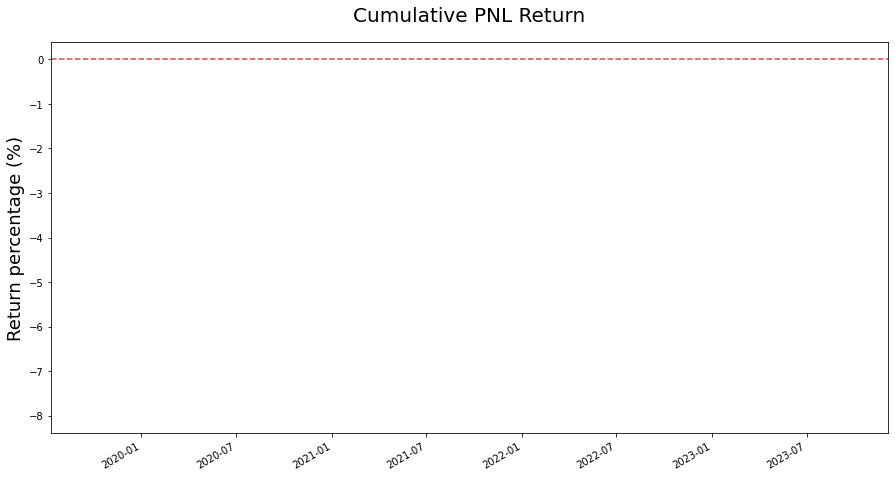

In [993]:
# Charting the cumulative return
ax = df_pnl['cumulative_return'].plot(figsize=(15,8))
ax.axhline(y=0, color='#D74A4B', linestyle='--')
ax.set_ylabel('Return percentage (%)', fontsize=18)
ax.set_xlabel('')
ax.set_title('Cumulative PNL Return', fontsize=20, pad=20)

plt.show()

# 7. Alternative strategy (two moving averages)

Another strategy is to apply two moving averages to a chart: one longer and one shorter. When the shorter-term MA crosses above the longer-term MA, it's a `BUY` signal, as it indicates that the trend is shifting up. This is known as a **"golden cross."**

Meanwhile, when the shorter-term MA crosses below the longer-term MA, it's a `SELL` signal, as it indicates that the trend is shifting down. This is known as a **"dead/death cross."**

In [994]:
# declare new variable for the longer moving average period
ma_period_long = 60 # period in days

In [995]:
# create moving average column based on the period selected
df['moving_avg_long'] = df['close'].rolling(ma_period_long).mean()

# filtering only data for the period of trading, in this case starting from 2019 onwards
df2 = df.loc['2019':, ['close', 'moving_avg', 'moving_avg_long']]

<AxesSubplot:xlabel='date'>

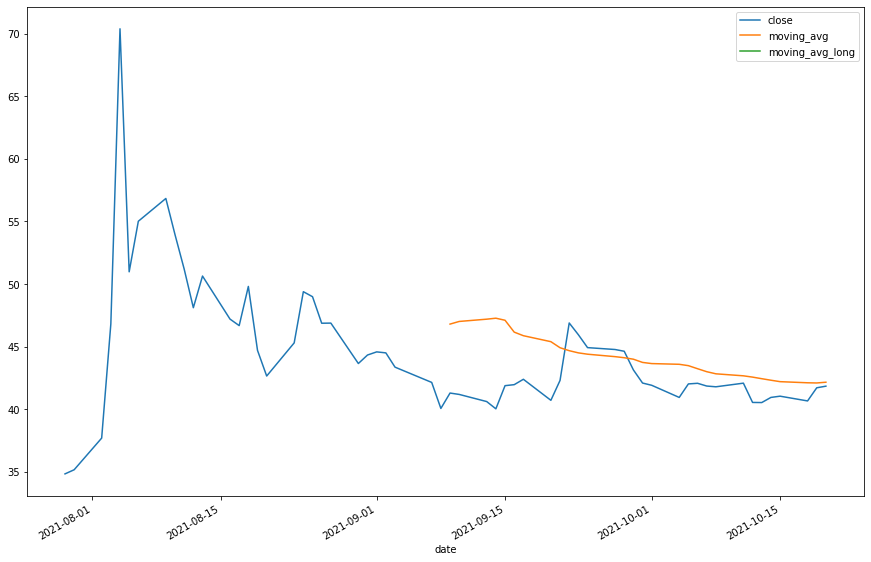

In [996]:
df2.plot(figsize=(15,10))

### Replicating step 4 to the new strategy

In [997]:
# create new column to indicate buy and sell action
df2['action'] = ''

# place the iloc indexes of each column to variables for easier reference
moving_avg_col_index = df2.columns.get_loc('moving_avg')
moving_avg_long_col_index = df2.columns.get_loc('moving_avg_long')
action_col_index = df2.columns.get_loc('action')

# same logic as the previous strategy but now close price is replaced with the shorter term moving average
for i in range(1, len(df2)):
    if (df2.iloc[i-1,moving_avg_col_index] < df2.iloc[i-1,moving_avg_long_col_index]) & (df2.iloc[i,moving_avg_col_index] > df2.iloc[i,moving_avg_long_col_index]):
        df2.iloc[i,action_col_index] = 'Buy'
    elif (df2.iloc[i-1,moving_avg_col_index] > df2.iloc[i-1,moving_avg_long_col_index]) & (df2.iloc[i,moving_avg_col_index] < df2.iloc[i,moving_avg_long_col_index]):
        df2.iloc[i,action_col_index] = 'Sell'
    else:
        df2.iloc[i,action_col_index] = ''


In [998]:
# HANDLING EXCEPTIONS
# printing the first instances of the BUY and SELL actions
print(f"First occurence of BUY order: {df2['action'].eq('Buy').idxmax()}")
print(f"First occurence of SELL order: {df2['action'].eq('Sell').idxmax()}")

# set first row as 'Buy' if the start price of the period is already above the moving average price
if df2['action'].eq('Buy').idxmax() > df2['action'].eq('Sell').idxmax():
    df2.iloc[0,action_col_index] = 'Buy'
    print("First row set to BUY")
else:
    df2.iloc[0,action_col_index] = df2.iloc[0,action_col_index]
    print("No change")

print("-"*10)

# printing the last instances of the BUY and SELL actions
print(f"Last occurence of BUY order: {df2['action'].where(df2['action'] == 'Buy').last_valid_index()}")
print(f"Last occurence of SELL order: {df2['action'].where(df2['action'] == 'Sell').last_valid_index()}")

# set last row as 'Sell' if the end price of the period is still above the moving average price
if df2['action'].where(df2['action'] == 'Buy').last_valid_index() > df2['action'].where(df2['action'] == 'Sell').last_valid_index():
    df2.iloc[len(df2)-1,action_col_index] = 'Sell'
    print("Last row set to SELL")
else:
    df2.iloc[len(df2)-1,action_col_index] = df2.iloc[len(df2)-1,action_col_index]
    print("No change")
    
print("-"*10)

First occurence of BUY order: 2021-07-29 00:00:00
First occurence of SELL order: 2021-07-29 00:00:00
No change
----------
Last occurence of BUY order: None
Last occurence of SELL order: None


TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
# filtering only days with actions
df_action_2 = df2.loc[df2['action'] != '', ['close', 'action']]
df_action_2.head(10)

### Replicating step 5 to the new strategy

In [ ]:
# create a new data frame to summarize trades in a row format
df_pnl_2 = df_action_2.loc[df_action_2['action'] == 'Buy', ['close']]

# rename column to buy_px
df_pnl_2.rename(columns={'close':'buy_px'}, inplace=True)

# insert a new column from a list of the SELL prices
df_pnl_2['sell_px'] = df_action_2.loc[df_action_2['action'] == 'Sell', ['close']]['close'].tolist()

# insert a new column for the trade dates of the SELL actions
df_pnl_2['sold_date'] = df_action_2.loc[df_action_2['action'] == 'Sell', ['close']].index.tolist()

# create column that shows the difference in SELL price and BUY price
df_pnl_2['pnl'] = df_pnl_2['sell_px'] - df_pnl_2['buy_px']

# convert that into percentage to get return per trade
df_pnl_2['return_pct'] = 100*df_pnl_2['pnl']/df_pnl_2['buy_px']

# calculate cumulative return (in %) using cumprod() function
df_pnl_2['sell_over_buy'] = df_pnl_2['sell_px']/df_pnl_2['buy_px']
df_pnl_2['cumulative_return'] = (df_pnl_2['sell_over_buy'].cumprod()-1)*100 # in percentage

df_pnl_2

In [ ]:
print(f"Total number of trades: {len(df_pnl_2)}")

### Result of the new strategy

In [ ]:
print("-"*10)
print(f"Average stock price BOUGHT: ${df_pnl_2['buy_px'].mean():.2f}")
print(f"Average stock price SOLD: ${df_pnl_2['sell_px'].mean():.2f}")
print("-"*10)
print(f"Total cumulative return of new strategy: {(df_pnl_2['cumulative_return'][len(df_pnl_2)-1]):.2f}%")
print(f"Total cumulative return of previous strategy: {(df_pnl['cumulative_return'][len(df_pnl)-1]):.2f}%")
print(f"Difference: {(df_pnl_2['cumulative_return'][len(df_pnl_2)-1])-(df_pnl['cumulative_return'][len(df_pnl)-1]):.2f}%")

### Plotting the cumulative returns of the two strategies

In [ ]:
# merging the two pnl tables
df_compare = pd.merge(df_pnl,df_pnl_2, how='outer', left_index=True, right_index=True)
df_compare.head()

In [ ]:
# dropping non-essential columns
df_compare.drop(columns=['buy_px_x', 'sell_px_x', 'sold_date_x', 'pnl_x', 'return_pct_x', 'sell_over_buy_x', 'buy_px_y', 'sell_px_y', 'sold_date_y', 'pnl_y', 'return_pct_y', 'sell_over_buy_y'], inplace=True)

# renaming column to "close"
df_compare.rename(columns={'cumulative_return_x':'strategy_1', 'cumulative_return_y':'strategy_2'}, inplace=True)

df_compare.head()

In [ ]:
# creating a new data frame with complete dates from first day of trade to last day of trade in order to create a step diagram
full_date = pd.DataFrame({'date': pd.date_range(df_compare.index.min(), df_compare.index.max(), freq='D')})
full_date = full_date.set_index('date')
full_date = pd.merge(full_date, df_compare, how='left', left_index=True, right_index=True).fillna(method='ffill')

full_date.plot(figsize=(15,8))
plt.ylabel('Return percentage (%)', fontsize=18)
plt.xlabel('')
plt.title('Cumulative PNL Return Comparison', fontsize=20, pad=20)

plt.show()